In [2]:
# Import phase if every import is here it is to allow you to run this cell and know if you have any issue and not after a few hours of training

import tensorflow
from tensorflow import keras
import os
import numpy as np
import librosa

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Activation, Flatten, MaxPooling1D, BatchNormalization, LSTM, GaussianNoise
from tensorflow.keras.models import Sequential


from src.VoiceModule import VoiceModule
from src.classifiers.KerasClassifier import KerasClassifier
from prepare_data_utils import load_wav, preprare_wav


In [32]:
# print environment
folder_path = "../../data"
for l in os.listdir(folder_path):
    print(l)

bdes.zip
fearful
savee
calm
happy
surprised
angry
sad
keywords


In [4]:
# Transform data method

def mfcc(buffer, samplerate, dim):
    a = librosa.feature.mfcc(y=buffer, sr=samplerate, n_mfcc=dim)
    a = np.transpose(a)
    return a


In [5]:
# Create callback to later draw some graphs

class PerformanceLogger(Callback):
    def __init__(self):
        # List of tuple (loss, accuracy)
        self.training = []
        self.testing = []
    def on_epoch_end(self, epoch, logs=None):
        self.training.append((logs["loss"], logs["acc"]))
        self.testing.append((logs["val_loss"], logs["val_acc"]))

In [6]:
# This function prints metrics about a model
def print_metrics(X, Y, label_name_list):
    Y_pred = vm.model._model.predict(X)
    Y_pred = np.argmax(Y_pred, axis=1)
    Y_max = np.argmax(Y, axis=1)
    print(confusion_matrix(Y_max, Y_pred))
    print(classification_report(Y_max, Y_pred, target_names=label_name_list))


In [22]:
# Create class
class EmotionClassifierCnn(KerasClassifier):
    def __init__(self, file_path=None):
        super().__init__(file_path)

    def predict(self, x):
        x = np.expand_dims(np.array([x]), axis=2)
        return self._model.predict(x)

    def build(self):
        model = Sequential()
        model.add(GaussianNoise(0.4))
        model.add(BatchNormalization())
        model.add(Conv1D(64, 3, input_shape=(35, 13), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(BatchNormalization())
        model.add(Dropout(0.4))
        model.add(GaussianNoise(0.4))
        model.add(Dense(64))
        model.add(Dense(6))
        model.add(Activation('softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        self._model = model
        
    def train(self, X, Y, batch_size=32, epoch=720, validation_data=None, callbacks=[]):
        self._model.fit(X, Y, batch_size=batch_size, epochs=epoch, validation_data=validation_data, callbacks=callbacks)

    def transform(self, x, samplerate):
        to_process = mfcc(x, samplerate, 13)
        to_process = pad_sequences([to_process], maxlen=35, padding='post')[0]
        return to_process


In [27]:
#Instanciate model
emotion_list = ["calm", "happy", "angry", "fearful", "surprised", "sad"]
dimension_mfcc = 13
samplerate = 16000
nb_break=None
sample_duration=1
step=0.5

logger = PerformanceLogger()

cls = EmotionClassifierCnn()
vm = VoiceModule("emotion-1s", emotion_list, cls)

In [11]:
# Prepare data for training
data = {f: load_wav(f"{folder_path}/{f}", nb_break) for f in emotion_list}
X, Y = preprare_wav(data, vm, sample_duration, step)
print("Done")

Doing calm
Doing happy
Doing angry
Doing fearful
Doing surprised
Doing sad
Done


In [11]:
X_file = f"x_{'_'.join(emotion_list)}-{vm._name}.npy"
Y_file = f"y_{'_'.join(emotion_list)}.npy"

In [14]:
# Saving the prepared input data 
np.save(X_file, X)
np.save(Y_file, Y)


In [12]:
# Load data for training
X, Y = np.load(X_file), np.load(Y_file)

In [13]:
"""train_size = 80 * len(X) // 100
test_size = 20 * len(X) // 100
#X = np.expand_dims(X, axis=3)
X_train, X_test, = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]"""
X = X.astype('float32')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(len(X_train), len(X_test))

print(X[0].shape)
print( X.dtype)

5435 1359
(35, 13)
float32


In [28]:
vm.model.train(X_train, Y_train, batch_size=64, epoch=100, validation_data=(X_test, Y_test), callbacks=[logger])

Train on 5435 samples, validate on 1359 samples
Epoch 1/100
5435/5435 [==============================] - 2s 396us/sample - loss: 2.3959 - acc: 0.2826 - val_loss: 2.1112 - val_acc: 0.2995
Epoch 2/100
5435/5435 [==============================] - 2s 312us/sample - loss: 1.7286 - acc: 0.3776 - val_loss: 1.7016 - val_acc: 0.3223
Epoch 3/100
5435/5435 [==============================] - 2s 310us/sample - loss: 1.5915 - acc: 0.3989 - val_loss: 1.4749 - val_acc: 0.3996
Epoch 4/100
5435/5435 [==============================] - 2s 311us/sample - loss: 1.4934 - acc: 0.4250 - val_loss: 1.4324 - val_acc: 0.4165
Epoch 5/100
5435/5435 [==============================] - 2s 308us/sample - loss: 1.4295 - acc: 0.4456 - val_loss: 1.3950 - val_acc: 0.4371
Epoch 6/100
5435/5435 [==============================] - 2s 312us/sample - loss: 1.3706 - acc: 0.4666 - val_loss: 1.3640 - val_acc: 0.4393
Epoch 7/100
5435/5435 [==============================] - 2s 305us/sample - loss: 1.3232 - acc: 0.4810 - val_loss: 1.32

5435/5435 [==============================] - 2s 308us/sample - loss: 0.9612 - acc: 0.6245 - val_loss: 1.1282 - val_acc: 0.5585
Epoch 60/100
5435/5435 [==============================] - 2s 311us/sample - loss: 0.9531 - acc: 0.6386 - val_loss: 1.1385 - val_acc: 0.5533
Epoch 61/100
5435/5435 [==============================] - 2s 310us/sample - loss: 0.9492 - acc: 0.6316 - val_loss: 1.1338 - val_acc: 0.5600
Epoch 62/100
5435/5435 [==============================] - 2s 310us/sample - loss: 0.9206 - acc: 0.6449 - val_loss: 1.1150 - val_acc: 0.5592
Epoch 63/100
5435/5435 [==============================] - 2s 310us/sample - loss: 0.9315 - acc: 0.6460 - val_loss: 1.1226 - val_acc: 0.5533
Epoch 64/100
5435/5435 [==============================] - 2s 309us/sample - loss: 0.9504 - acc: 0.6329 - val_loss: 1.1428 - val_acc: 0.5438
Epoch 65/100
5435/5435 [==============================] - 2s 314us/sample - loss: 0.9451 - acc: 0.6328 - val_loss: 1.1485 - val_acc: 0.5453
Epoch 66/100
5435/5435 [=========

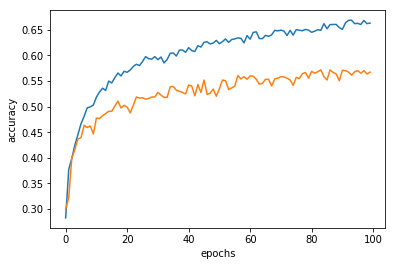

[[164  24   4   8  16  30]
 [  9 121  24  25  24  15]
 [  5  24 164  19  12  12]
 [  6  22  30 111  25  17]
 [  9  28  19  32 103  21]
 [ 39  33  15  26  15 108]]
              precision    recall  f1-score   support

        calm       0.71      0.67      0.69       246
       happy       0.48      0.56      0.51       218
       angry       0.64      0.69      0.67       236
     fearful       0.50      0.53      0.51       211
   surprised       0.53      0.49      0.51       212
         sad       0.53      0.46      0.49       236

    accuracy                           0.57      1359
   macro avg       0.57      0.56      0.56      1359
weighted avg       0.57      0.57      0.57      1359



In [30]:

plt.plot(list(range(0, len(logger.training))), list(map(lambda x:x[1], logger.training)), label="training data")
plt.plot(list(range(0, len(logger.testing))), list(map(lambda x:x[1], logger.testing)), label="testing data")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()
print_metrics(X_test, Y_test, emotion_list)

In this graph we can see that the model largely overfit around the 20st epoch
We can also see that the testing data's accuracy continues to grow.

In [29]:
# Now we save the model so we don't have to retrain it each time
vm.model.save("emotion_cnn-1s.model")

In [37]:
# Here we load the model to check if nothing went wrong
vm.model.load("emotion_lstm-1s.model")

In [33]:
# Now we load the new dataset (savee)

# First we change the folder path
folder_path += "/savee"

# Now we load the data
data = {f: load_wav(f"{folder_path}/{f}", nb_break) for f in emotion_list}
X_savee, Y_savee = preprare_wav(data, vm, sample_duration, step)
X_savee = X_savee.astype('float32')
X_savee_train, X_savee_test, Y_savee_train, Y_savee_test = train_test_split(X_savee, Y_savee, test_size=0.2, random_state=42)

Doing calm
Doing happy
Doing angry
Doing fearful
Doing surprised
Doing sad


In [34]:
print(X_savee.shape)
vm.model._model.evaluate(X_savee, Y_savee)
print_metrics(X_savee, Y_savee, emotion_list)

(2582, 35, 13)
2582/2582 [==============================] - 0s 131us/sample - loss: 7.2557 - acc: 0.2091
[[ 58 219 180   0 155  73]
 [ 13 126 106   5  89  29]
 [  7  91 141   0  98  21]
 [ 15  85 126   3 106  23]
 [  7  77  93   9 156  21]
 [ 36 122 141   7  88  56]]
              precision    recall  f1-score   support

        calm       0.43      0.08      0.14       685
       happy       0.17      0.34      0.23       368
       angry       0.18      0.39      0.25       358
     fearful       0.12      0.01      0.02       358
   surprised       0.23      0.43      0.30       363
         sad       0.25      0.12      0.17       450

    accuracy                           0.21      2582
   macro avg       0.23      0.23      0.18      2582
weighted avg       0.26      0.21      0.18      2582



In [35]:
# Now we freeze every layer used for extracting features from data
for layer in vm.model._model.layers[:-3]:
    print(layer.name)
    layer.trainable = False
vm.model._model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

gaussian_noise_2
batch_normalization_2
conv1d_1
activation_2
max_pooling1d_1
flatten_1
batch_normalization_3
dropout_1
gaussian_noise_3


In [36]:
# And we train the two last layers
# This is classic fine tuning
vm.model.train(X_savee_train, Y_savee_train, batch_size=10, validation_data=(X_savee_test, Y_savee_test), epoch=100)

Train on 2065 samples, validate on 517 samples
Epoch 1/100
2065/2065 [==============================] - 2s 913us/sample - loss: 1.6701 - acc: 0.3419 - val_loss: 3.4358 - val_acc: 0.3578
Epoch 2/100
2065/2065 [==============================] - 2s 787us/sample - loss: 1.3238 - acc: 0.4547 - val_loss: 4.5347 - val_acc: 0.3617
Epoch 3/100
2065/2065 [==============================] - 2s 770us/sample - loss: 1.2746 - acc: 0.4872 - val_loss: 3.8573 - val_acc: 0.3830
Epoch 4/100
2065/2065 [==============================] - 2s 773us/sample - loss: 1.2522 - acc: 0.5031 - val_loss: 3.9890 - val_acc: 0.3868
Epoch 5/100
2065/2065 [==============================] - 2s 752us/sample - loss: 1.1888 - acc: 0.5177 - val_loss: 4.2616 - val_acc: 0.3830
Epoch 6/100
2065/2065 [==============================] - 2s 748us/sample - loss: 1.1902 - acc: 0.5337 - val_loss: 4.4251 - val_acc: 0.3636
Epoch 7/100
2065/2065 [==============================] - 2s 758us/sample - loss: 1.1551 - acc: 0.5259 - val_loss: 5.012

2065/2065 [==============================] - 2s 761us/sample - loss: 1.0328 - acc: 0.6000 - val_loss: 4.7415 - val_acc: 0.3965
Epoch 60/100
2065/2065 [==============================] - 2s 771us/sample - loss: 1.0737 - acc: 0.5869 - val_loss: 5.3767 - val_acc: 0.3694
Epoch 61/100
2065/2065 [==============================] - 2s 764us/sample - loss: 1.0573 - acc: 0.5816 - val_loss: 4.7294 - val_acc: 0.3714
Epoch 62/100
2065/2065 [==============================] - 2s 762us/sample - loss: 1.0669 - acc: 0.5821 - val_loss: 5.0207 - val_acc: 0.3714
Epoch 63/100
2065/2065 [==============================] - 2s 763us/sample - loss: 1.0514 - acc: 0.5763 - val_loss: 5.1709 - val_acc: 0.3714
Epoch 64/100
2065/2065 [==============================] - 2s 759us/sample - loss: 1.0977 - acc: 0.5855 - val_loss: 5.3795 - val_acc: 0.3636
Epoch 65/100
2065/2065 [==============================] - 2s 754us/sample - loss: 1.0795 - acc: 0.5627 - val_loss: 4.2547 - val_acc: 0.3830
Epoch 66/100
2065/2065 [=========

In [38]:
print_metrics(X_savee_test, Y_savee_test, emotion_list)

[[142   0   0   0   0   2]
 [ 41   3  20   0   0   3]
 [ 34   0  43   0   0   5]
 [ 38   1  22   1   1  11]
 [ 34   8  19   0   2   3]
 [ 76   0   0   0   0   8]]
              precision    recall  f1-score   support

        calm       0.39      0.99      0.56       144
       happy       0.25      0.04      0.08        67
       angry       0.41      0.52      0.46        82
     fearful       1.00      0.01      0.03        74
   surprised       0.67      0.03      0.06        66
         sad       0.25      0.10      0.14        84

    accuracy                           0.38       517
   macro avg       0.49      0.28      0.22       517
weighted avg       0.48      0.38      0.27       517

